In [1]:
import pandas as pd
df = pd.read_csv('c:/data/ozone/ozone2.csv')
df

,Ozone,Result,Solar.R,Wind,Temp,Month,Day
0,41.00000,0,190.000000,7.4,67,5,1
1,36.00000,0,118.000000,8.0,72,5,2
2,12.00000,0,149.000000,12.6,74,5,3
3,18.00000,0,313.000000,11.5,62,5,4
4,42.12931,1,185.931507,14.3,56,5,5
...,...,...,...,...,...,...,...
148,30.00000,0,193.000000,6.9,70,9,26
149,42.12931,1,145.000000,13.2,77,9,27
150,14.00000,0,191.000000,14.3,75,9,28
151,18.00000,0,131.000000,8.0,76,9,29


<AxesSubplot:>

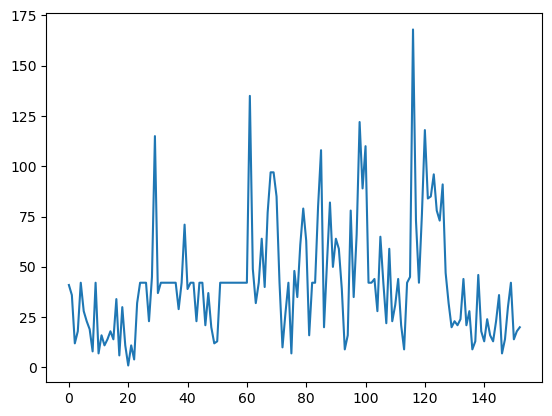

In [2]:
df['Ozone'].plot() # 불안정한 시계열

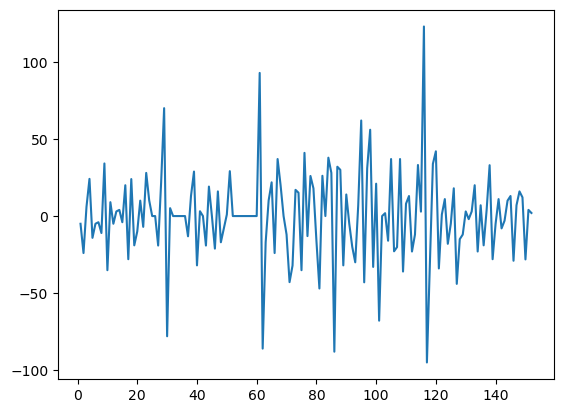

In [3]:
#1차 차분 데이터
import matplotlib.pyplot as plt
diff1 = df['Ozone'].diff(periods=1).iloc[1:]
diff1.plot()
plt.show()

In [4]:
#로그 후 차분한 자료가 안정적인 시계열인지 확인
from statsmodels.tsa.stattools import adfuller
import numpy as np
diff1 = np.log(df['Ozone']).diff(periods=1).iloc[1:]
result = adfuller(diff1)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

(-9.189875590717376, 2.1375829081178104e-15, 3, 148, {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}, 289.55299350103235)
ADF Statistic: -9.189876
p-value: 0.000000


In [5]:
#가장 적절한 모형
from pmdarima.arima import auto_arima
model = auto_arima(df['Ozone'], suppress_warnings=True)
model

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [6]:
#학습용, 검증용 구분
n = int(df.shape[0] * 0.8)
train = df[:n]
test = df[n:]
print(len(df['Ozone']))
print(train['Ozone'].values)
print(test['Ozone'].values)

153
[ 41.          36.          12.          18.          42.12931034
  28.          23.          19.           8.          42.12931034
   7.          16.          11.          14.          18.
  14.          34.           6.          30.          11.
   1.          11.           4.          32.          42.12931034
  42.12931034  42.12931034  23.          45.         115.
  37.          42.12931034  42.12931034  42.12931034  42.12931034
  42.12931034  42.12931034  29.          42.12931034  71.
  39.          42.12931034  42.12931034  23.          42.12931034
  42.12931034  21.          37.          20.          12.
  13.          42.12931034  42.12931034  42.12931034  42.12931034
  42.12931034  42.12931034  42.12931034  42.12931034  42.12931034
  42.12931034 135.          49.          32.          42.12931034
  64.          40.          77.          97.          97.
  85.          42.12931034  10.          27.          42.12931034
   7.          48.          35.          61.          

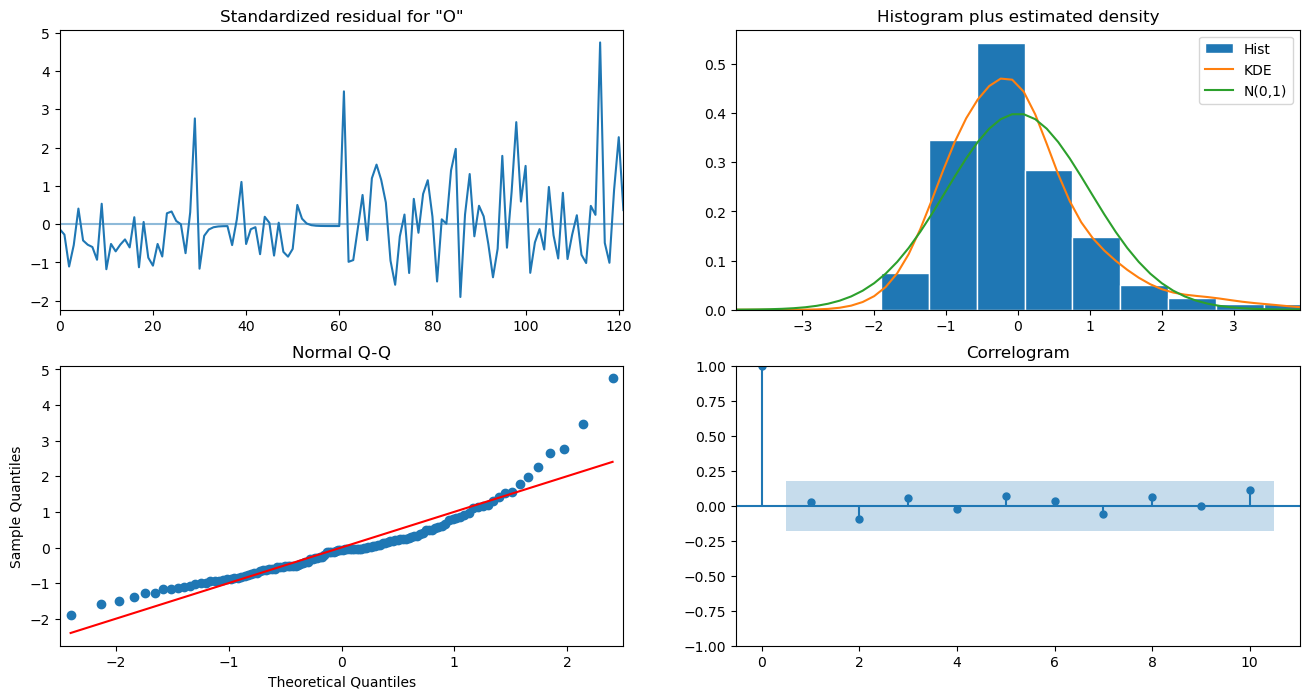

In [7]:
#가장 적절한 모형 생성
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Ozone'], order=(1,0,1)).fit()
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [8]:
#예측값
predictions = model.predict(start=1, end=len(test), dynamic=False)
predictions.index = len(train) + (predictions.index) - 1
predictions

122    43.289071
123    41.239691
124    32.405625
125    31.380850
126    39.214510
127    37.155467
128    34.739014
129    32.537098
130    28.034203
131    38.045134
132    29.619145
133    29.730096
134    28.071767
135    28.510646
136    30.021653
137    29.191885
138    35.690358
139    28.457031
140    34.075945
141    29.590091
142    24.628666
143    26.289463
144    24.493770
145    33.370124
146    39.909363
147    42.193999
148    42.992191
149    36.778213
150    42.074424
151    67.684083
152    50.156765
Name: predicted_mean, dtype: float64

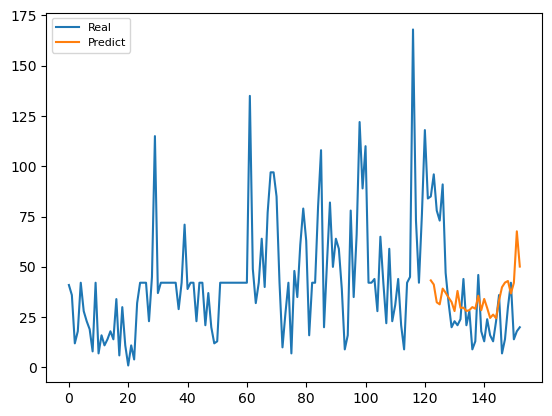

In [9]:
#시각화
plt.plot(df['Ozone'], label='Real')
plt.plot(predictions, label='Predict')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
#오차 확인
def _error(real, pred):
    return real - pred

def mse(real, pred):
    return np.mean(np.square(_error(real, pred)))

def rmse(real, pred):
    return np.sqrt(mse(real, pred))

def mae(real, pred):
    return np.mean(np.abs(_error(real, pred)))

METRICS = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
}

def evaluate(real, pred, metrics=('mse', 'rmse', 'mae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](real, pred)
        except:
            results[name] = np.nan
    return results

evaluate(test['Ozone'].values, predictions.values)

{'mse': 644.8720675414185,
 'rmse': 25.394331405678287,
 'mae': 19.619085236543743}